# SYSID - Atividade 05

Aluno: Pedro Henrique Cardoso Paulo<br>

Professor: Helon

## Objetivo

Nessa atividade vamos tentar aplicar os fundamentos da identificação contínua de sistemas. Devido a problemas com o Octave essa atividade será feita em Python, fazzendo uso das bibliotecas `scikitt-learn`, `control`, `scipy` e `numpy`

## Arquivos de suporte

Na pasta deste notebook poderão ser encontrados dois arquivos com funções e classes de suporte:

* <a href="./time_processing.py">time_processing.py</a>: pacote com função para reamostragem do sinal no tempo fazendo uso de interpolação
* <a href="./ContinuousDerivativePreprocessor.py">ContinuousDerivativePreprocessor.py</a>: tentativa de implementar, com a sitaxe sklearn um preprocessador de derivadas temporais

## Passo 0 - Importando bibliotecas

In [45]:
#Desabilitando warnings
#def warn(*args, **kwargs):
#    pass
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
#warnings.warn = warn

# Pacotes padrao
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
import datetime

# Pacotes customizados
from time_processing import *
from ContinuousDerivativePreprocessor import CDProcessor

# Compatibilidade matlab
import control.matlab as mtlb

#Pipeline
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV

#Definindo random_state
rs = 85

## Passo 0 - Importando os dados

### 0.1 - Lendo dados

In [2]:
data = np.genfromtxt('../data/measured_data.csv')
t = data[:,0]
y = data[:,5]
X = data[:,2]

### 0.2 - Visualizando dados

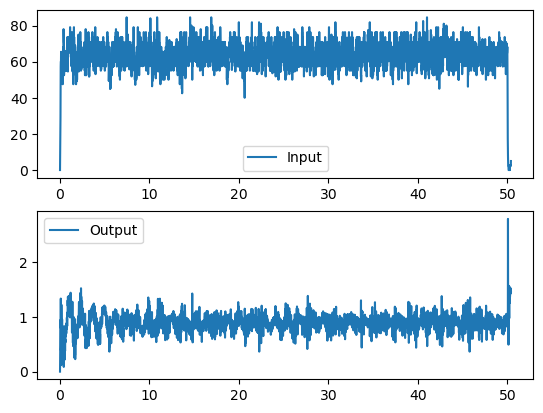

In [3]:
fig, ax = plt.subplots(2,1)
ax[0].plot(t, X, label='Input')
ax[1].plot(t, y, label='Output')
ax[0].legend()
ax[1].legend()

## Passo 1 - Aplicando a reamostragem

A reamostragem seré feita de modo a garantirmos um passo de tempo constante entre as amostras.

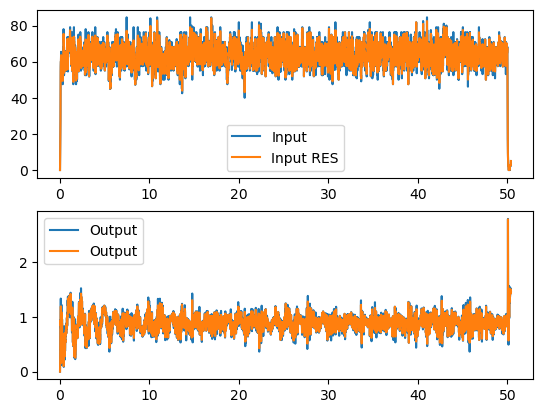

In [4]:
t_out, X_out, y_out = interpolation_resample(t, X, y, frequency=100)

fig, ax = plt.subplots(2,1)
ax[0].plot(t, X, label='Input')
ax[1].plot(t, y, label='Output')
ax[0].plot(t_out, X_out, label='Input RES')
ax[1].plot(t_out, y_out, label='Output')
ax[0].legend()
ax[1].legend()

## Passo 2 - Definindo a derivação do sinal de entrada

Para esse exemplo, ainda focaremos em um exemplo básico, sem uso das ferramentas de RandomizedSearch do Scikit-Learn. Para a estimativa de derivadas, vamos usar o pacote `control.matlab` para plicar uma função de transferência ao sinal que temos no momento. Dessa forma, para a estimativa da i-ésima derivada de um total de n derivadas de dada função no domínio de Laplace, podemos usar a seguinte função de transferência:

\begin{equation}
G_i(s) = \frac{\lambda^ns^i}{(s + \lambda)^n}
\end{equation}

Nessa função, o denominador representa um filtro passa baixa para uma frequência $\lambda$.

### 2.1 - Estudando a frequência de corte

In [5]:
s = mtlb.tf('s')
order = 5
frequency_vals = [0.1,1,2,3]

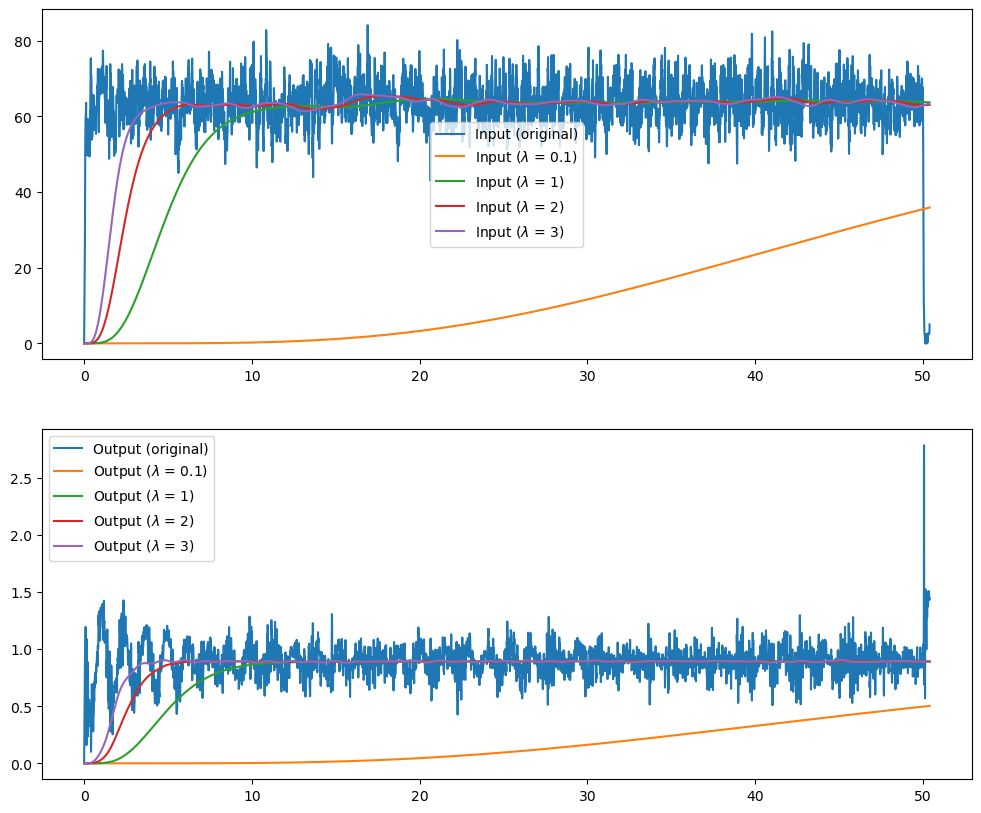

In [6]:
fig, ax = plt.subplots(2,1, figsize=(12, 10))
ax[0].plot(t_out, X_out, label='Input (original)')
ax[1].plot(t_out, y_out, label='Output (original)')

for frequency in frequency_vals:
    G = (frequency**order) * (1 / (s + frequency)**order)
    Xfilt, tfilt, _ = mtlb.lsim(G, X_out, t_out)
    yfilt, tfilt, _ = mtlb.lsim(G, y_out, t_out)

    ax[0].plot(tfilt, Xfilt, label=f'Input ($\lambda$ = {frequency})')
    ax[1].plot(tfilt, yfilt, label=f'Output ($\lambda$ = {frequency})')

ax[0].legend()
ax[1].legend()

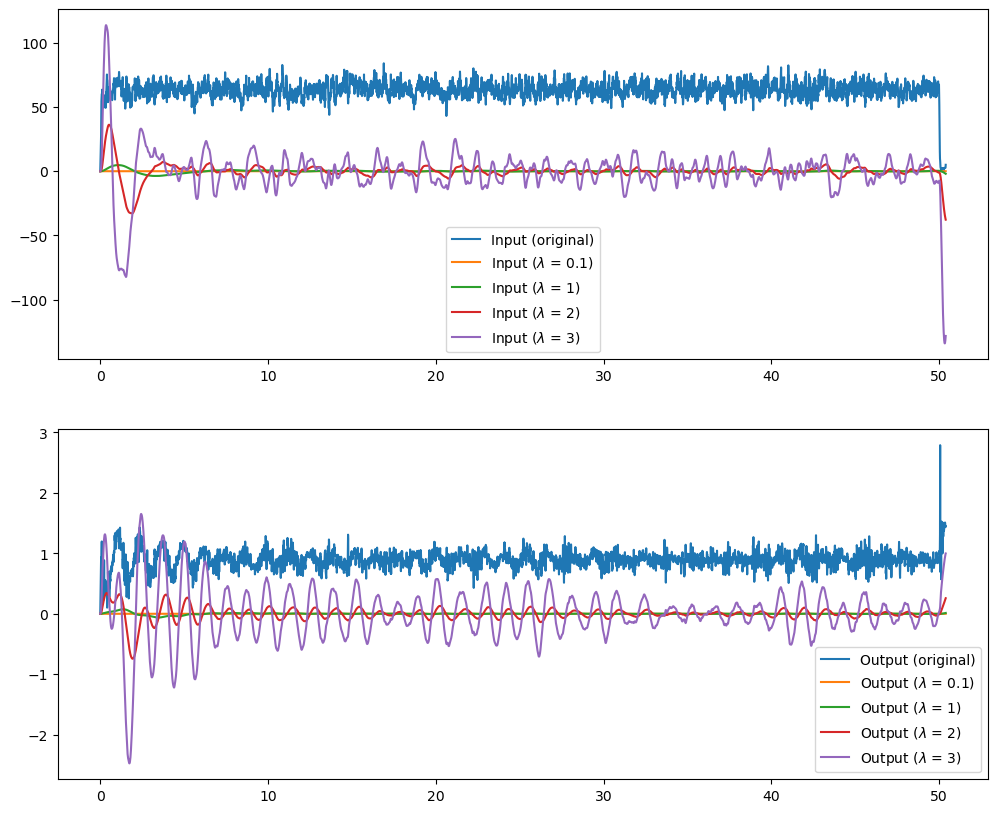

In [7]:
fig, ax = plt.subplots(2,1, figsize=(12, 10))
ax[0].plot(t_out, X_out, label='Input (original)')
ax[1].plot(t_out, y_out, label='Output (original)')

for frequency in frequency_vals:
    G = (frequency**order) * (s**3 / (s + frequency)**order)
    Xfilt, tfilt, _ = mtlb.lsim(G, X_out, t_out)
    yfilt, tfilt, _ = mtlb.lsim(G, y_out, t_out)

    ax[0].plot(tfilt, Xfilt, label=f'Input ($\lambda$ = {frequency})')
    ax[1].plot(tfilt, yfilt, label=f'Output ($\lambda$ = {frequency})')

ax[0].legend()
ax[1].legend()

## Passo 3 - Montando matriz de entrada e separando treino e teste

In [55]:
p_train = 0.7

In [73]:
X1 = np.hstack([
    np.array(t_out).reshape(-1,1), 
    X_out.reshape(-1,1), 
    y_out.reshape(-1,1),
    ])

n_train = int(X1.shape[0]*p_train)
X1_tr = X1[:n_train,:]
y_tr = y_out[:n_train]
t_tr = t_out[:n_train]
X1_te = X1[n_train:,:]
y_te = y_out[n_train:]
t_te = t_out[n_train:]

In [58]:
def declara_Pipeline(tupla_metodo):
    
    steps = [
        ('PreProcessor', CDProcessor(output_cols=[1])),
        tupla_metodo,
    ]
    return Pipeline(steps)

## Passo 4 - Listando os modelos a serem testados e definindo hiperparâmetros a tunar

Nessa etapa, vamos criar a lista dos modelos que queremos testar.

### 4.1 - Lista de modelos testados

In [29]:
models = [
    ('LinReg', LinearRegression(fit_intercept=False)),
]
n_models = len(models)


### 4.2 - Lista de parâmetros

A lista é em grande parte inspirada nos testes que fizemos na Atividade 03. Algumas variáveis que não tinha sensibilidade (como gamme e epsilon dos kernels do SVM) usei os valores do material de aula.

In [189]:
parameters = [
    {
        'PreProcessor__order_X'          : stats.randint(1,10),
        'PreProcessor__order_y'          : stats.randint(1,10),
        'PreProcessor__frequency_cut'    : stats.uniform(1.0, 15.0),
    },
    
]

### 4.3 - Configurando KFolds

In [128]:

tmax = t_tr[-1]
nfolds = 3
rkf = [
    ((t_tr <= tmax/3),(tmax/3 < t_tr)&(t_tr <= 2*tmax/3),),
    ((tmax/3 < t_tr)&(t_tr <= 2*tmax/3),(2*tmax/3 < t_tr),),
]

## Passo 5 - Executando os modelos

Nossa comparação será realizada a partir de um loop padrão no qual extrairemos os seguintes valores:

* Tempo de execução do RandomSearchCV
* Melhores valores dos parâmetros
* Acurácia dos modelos nos conjuntos de treino e teste
* Matriz de confusão para cada caso

Iniciando avaliação do modelo: LinReg


/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/control/timeresp.py:935: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/control/timeresp.py:935: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/control/timeresp.py:935: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/control/timeresp.py:935: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
/home/pedro-linux/miniconda3

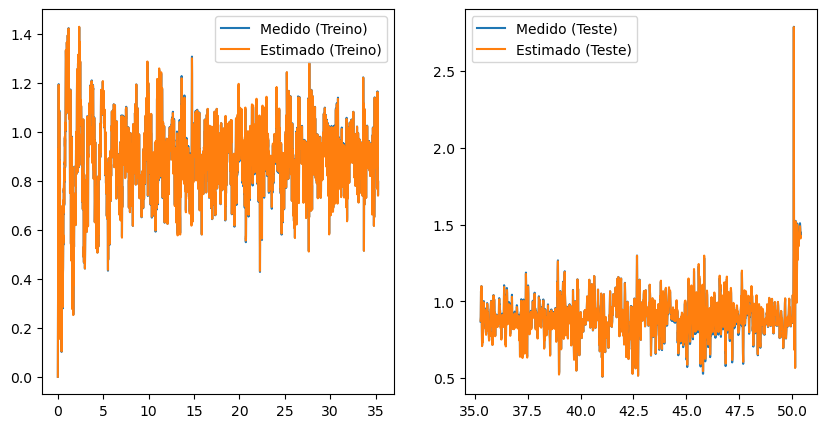

In [196]:
n_iter = 100 #Numero de iterações do rdmsearch 

fig, axs = plt.subplots(ncols=2, nrows=n_models, figsize=(10,n_models*5))

if n_models <= 1: axs = axs.reshape(1,-1)
#Loop principal, iterando sobre as listas
for i in range(n_models):
    
    model = models[i]
    params = parameters[i]
    #print(params)
    model_name = model[0]
    print('Iniciando avaliação do modelo: {}'.format(model_name))
    
    #Primeira etapa - criacao do Pipeline
    pipeline = declara_Pipeline(model)
    
    t0 = datetime.datetime.now()
    
    #rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
    
        rdmsearch = RandomizedSearchCV(pipeline, verbose=0, scoring='r2', 
                                        param_distributions=params, n_iter=n_iter, n_jobs=6, 
                                        cv=rkf, random_state=rs)
    
        rdmsearch.fit(X1_tr, y_tr)

    axs[i,0].plot(t_tr, y_tr, label='Medido (Treino)')
    axs[i,0].plot(t_tr, rdmsearch.predict(X1_tr), label='Estimado (Treino)')
    axs[i,0].legend()

    axs[i,1].plot(t_te, y_te, label='Medido (Teste)')
    axs[i,1].plot(t_te, rdmsearch.predict(X1_te), label='Estimado (Teste)')
    axs[i,1].legend()
    


In [191]:
best_pars = rdmsearch.best_params_
for best_par in best_pars.keys():
    print(best_par,':',best_pars[best_par])

PreProcessor__frequency_cut : 1.1910244149574714
PreProcessor__order_X : 6
PreProcessor__order_y : 9


In [192]:
param_linreg = rdmsearch.best_estimator_.named_steps['LinReg'].coef_
num = [p for p in param_linreg[:best_pars['PreProcessor__order_X']+1]]
den = [1] + [-p for p in param_linreg[best_pars['PreProcessor__order_X']+1:]]
print(param_linreg)
print(num[::-1], den[::-1])

[ 1.40052691e-02  2.30135991e-03  2.92008886e-02  1.17910554e-04
  3.85076845e-03 -1.64485039e-04  3.15988349e-05  4.88859882e+00
  2.02768047e+01  4.36722413e+01  5.66414989e+01  5.07439374e+01
  2.84215876e+01  1.05146378e+01  2.19171917e+00  2.07481462e-01]
[3.15988348689507e-05, -0.0001644850388141842, 0.0038507684510801178, 0.00011791055443531401, 0.029200888613466574, 0.002301359908462468, 0.014005269075545437] [-0.20748146218661082, -2.1917191672531886, -10.514637758420344, -28.421587580570208, -50.74393744602081, -56.64149893238242, -43.67224126596082, -20.27680465301045, -4.88859882258732, 1]


In [193]:
print('Score obtido para o grupo de treino (R2): {}'.format(rdmsearch.score(X1_tr, y_tr)))
print('Score obtido para o grupo de teste (R2):  {}'.format(rdmsearch.score(X1_te, y_te)))

Score obtido para o grupo de treino (R2): 0.9993018197682818
Score obtido para o grupo de teste (R2):  0.995746122353696


In [194]:
G2 = mtlb.tf(num[::-1], den[::-1])
print(G2)


       3.16e-05 s^6 - 0.0001645 s^5 + 0.003851 s^4 + 0.0001179 s^3 + 0.0292 s^2 + 0.002301 s + 0.01401
-------------------------------------------------------------------------------------------------------------
-0.2075 s^9 - 2.192 s^8 - 10.51 s^7 - 28.42 s^6 - 50.74 s^5 - 56.64 s^4 - 43.67 s^3 - 20.28 s^2 - 4.889 s + 1



In [195]:
lmbd = best_pars['PreProcessor__frequency_cut']
G3 = lmbd**2/(s + lmbd)**2
print(G3)


        1.419
---------------------
s^2 + 2.382 s + 1.419



In [184]:
y_tr_f = X1_tr[:,1]#mtlb.lsim(G3, X1_tr[:,1], t_tr)
y_te_f = X1_te[:,1]#mtlb.lsim(G3, X1_te[:,1], t_te)
y_tr_sim, t_tr_sim, _ = mtlb.lsim(G2, y_tr_f, t_tr)
y_te_sim, t_te_sim, _ = mtlb.lsim(G2, y_te_f, t_te)

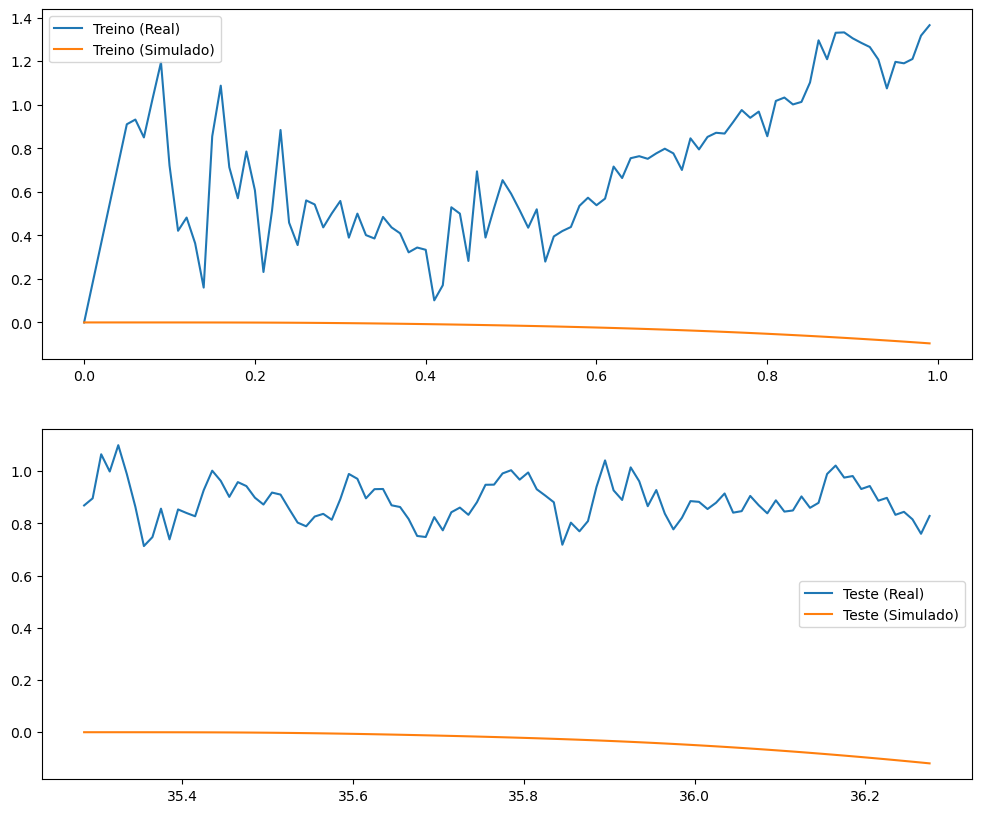

In [188]:
fig, ax = plt.subplots(2,1, figsize=(12,10))
ax[0].plot(t_tr[:100], y_tr[:100], label='Treino (Real)')
ax[1].plot(t_te[:100], y_te[:100], label='Teste (Real)')
ax[0].plot(t_tr_sim[:100], y_tr_sim[:100], label='Treino (Simulado)')
ax[1].plot(t_te_sim[:100], y_te_sim[:100], label='Teste (Simulado)')
ax[0].legend()
ax[1].legend()

### 5.4 - Conclusões do Passo 5

* Quanto aos métodos anteriormente testados, as conclusões não mudaram
* O DT apresentou bons resultados, mas não foi o mais interessante
* O RF apresentou bons resultados, mas tmabém não foi o mais interessante.
* O RF teve um desempenho numérico melhor que o SoftMax, mas foi pior como preditor

## Passo 6 - Comparando os resultados com o default

### 6.1 - Executando métodos default

A execução será feita considerando-se apenas os valores padrão já definidos na declaração dos métodos (vide lista de models).

Iniciando avaliação do modelo: SoftMax

    Tempo de execução: 0:00:00.116734
    Score treino: 0.9921568627450981
    Score teste : 0.9970588235294118

Iniciando avaliação do modelo: SVM

    Tempo de execução: 0:00:00.013726
    Score treino: 0.996078431372549
    Score teste : 1.0

Iniciando avaliação do modelo: KNN

    Tempo de execução: 0:00:00.003521
    Score treino: 0.9862745098039216
    Score teste : 0.9941176470588236

Iniciando avaliação do modelo: DT

    Tempo de execução: 0:00:00.008447
    Score treino: 1.0
    Score teste : 0.9470588235294117

Iniciando avaliação do modelo: RF

    Tempo de execução: 0:00:00.162582
    Score treino: 1.0
    Score teste : 0.9882352941176471



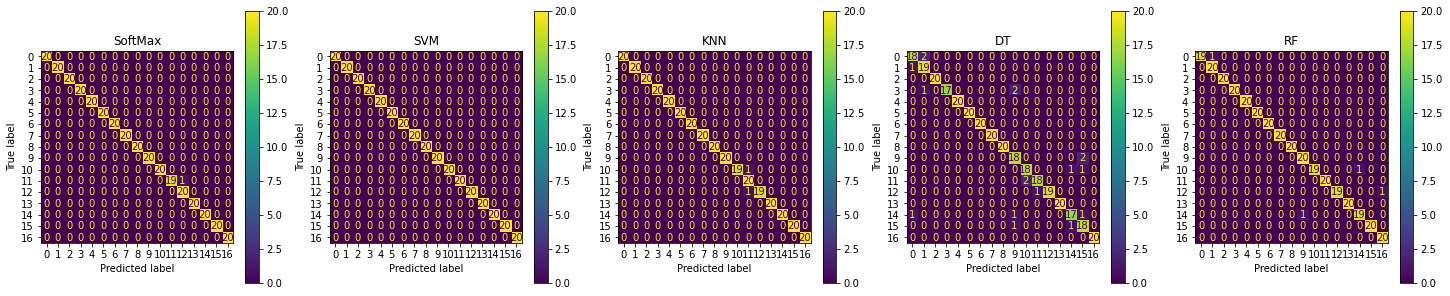

In [10]:
fig, axs = plt.subplots(ncols=n_models, nrows=1, figsize=(n_models*5,5))

#Loop principal, iterando sobre as listas
for model, params, ax in zip(models, parameters, axs):
    
    #print(params)
    model_name = model[0]
    print('Iniciando avaliação do modelo: {}'.format(model_name))
    
    #Primeira etapa - criacao do Pipeline
    pipeline = declara_Pipeline_MinMax(model)
    
    t0 = datetime.now()
    
    #rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)
    
    rdmsearch = pipeline
    
    rdmsearch.fit(X1_tr, y_tr)
    
    print()
    print('    Tempo de execução: {}'.format(datetime.now() - t0))
    print('    Score treino: {}'.format(rdmsearch.score(X1_tr, y_tr)))
    print('    Score teste : {}'.format(rdmsearch.score(X1_te, y_te)))
    print()
    
    cm = confusion_matrix(y_te, rdmsearch.predict(X1_te))
    cmgraph = ConfusionMatrixDisplay(cm)
    ax.set_title(model_name)
    cmgraph.plot(ax=ax)


### 6.2 - Conclusões

Pro nosso caso simples, os defaults ficaram bons.

## Passo 7 - Testando com diferentes treino-teste o Pipeline

Vamos tentar repetir o processo de treino-CV e teste para diversas seeds de random_state. Dessa forma, garantiremos a repetibilidade do processo.

### 7.1 - Criando estrutura de dados para armaazenar os resultados

In [23]:
resultados = {}

for model in models:
    
    resultados[model[0]] = []
    
print(json.dumps(resultados, indent=4))

{
    "SoftMax": [],
    "SVM": [],
    "KNN": [],
    "DT": [],
    "RF": []
}


### 7.2 - Criando lista de random seeds pro teste (pensando em repetibilidade)

In [27]:
n_tests = 5
rdmseeds = []
add = 0
while len(rdmseeds) < n_tests:
    rdmseeds = np.unique(stats.randint.rvs(1, 99, size=n_tests+add, random_state=rs))
    add += 1
for seed in rdmseeds:
    print(seed)

14
33
52
53
69


### 7.3 - Estruturando o loop

In [30]:
n_iter = 100 #Numero de iterações do rdmsearch 

#Loop principal, iterando sobre as listas
for seed in rdmseeds:
    
    X1_tr, X1_te, y_tr, y_te = train_test_split(X1, y, test_size=size, random_state=seed, stratify=y)
    print('Random seed = {}'.format(seed))
    print()
    
    for model, params in zip(models, parameters):
        
        #print(params)
        model_name = model[0]
        #if model_name == 'SoftMax': continue
        print('Iniciando avaliação do modelo: {}'.format(model_name))
        
        #Primeira etapa - criacao do Pipeline
        pipeline = declara_Pipeline_MinMax(model)
        
        t0 = datetime.now()
        
        #rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)
        
        rdmsearch = RandomizedSearchCV(pipeline, verbose=0, scoring='accuracy', 
                                       param_distributions=params, n_iter=n_iter, n_jobs=6, 
                                       cv=rkf, random_state=rs)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            rdmsearch.fit(X1_tr, y_tr)
        param_arq = rdmsearch.best_params_.copy() 
        print()
        print('    Tempo de execução: {}'.format(datetime.now() - t0))
        print('    Score treino: {}'.format(rdmsearch.score(X1_tr, y_tr)))
        param_arq['train_score'] = rdmsearch.score(X1_tr, y_tr)
        print('    Score teste : {}'.format(rdmsearch.score(X1_te, y_te)))
        param_arq['test_score'] = rdmsearch.score(X1_te, y_te)
        print()
        resultados[model_name].append(param_arq)
        print('    Resultados dos parâmetros:')
        for par in rdmsearch.best_params_.keys():
            print('        Parâmetro {}: {}'.format(par, rdmsearch.best_params_[par]))  
        print()
            


Random seed = 14

Iniciando avaliação do modelo: SoftMax


/mnt/d/Softwares/miniconda-linux/miniconda3/envs/ml_linux/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/mnt/d/Softwares/miniconda-linux/miniconda3/envs/ml_linux/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "



    Tempo de execução: 0:59:54.671569
    Score treino: 1.0
    Score teste : 0.9970588235294118

    Resultados dos parâmetros:
        Parâmetro PCA__n_components: 0.993317893040668
        Parâmetro SoftMax__penalty: none

Iniciando avaliação do modelo: SVM

    Tempo de execução: 0:02:06.367091
    Score treino: 1.0
    Score teste : 0.9970588235294118

    Resultados dos parâmetros:
        Parâmetro PCA__n_components: 0.9958205364243822
        Parâmetro SVM__C: 72.88769975399788
        Parâmetro SVM__degree: 2
        Parâmetro SVM__gamma: 0.005956936202510607
        Parâmetro SVM__kernel: linear

Iniciando avaliação do modelo: KNN

    Tempo de execução: 0:01:06.145486
    Score treino: 1.0
    Score teste : 0.9852941176470589

    Resultados dos parâmetros:
        Parâmetro KNN__n_neighbors: 10
        Parâmetro KNN__weights: distance
        Parâmetro PCA__n_components: 0.9858189335029848

Iniciando avaliação do modelo: DT

    Tempo de execução: 0:00:50.617310
    Score 

/mnt/d/Softwares/miniconda-linux/miniconda3/envs/ml_linux/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/mnt/d/Softwares/miniconda-linux/miniconda3/envs/ml_linux/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/mnt/d/Softwares/miniconda-linux/miniconda3/envs/ml_linux/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/mnt/d/Softwares/miniconda-linux/miniconda3/envs/ml_linux/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/mnt/d/Softwares/miniconda-linux/miniconda3/envs/ml_linux/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/mnt/d/Softwares/miniconda-linux/miniconda3/envs/ml_linux/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/mnt/d/Softwares/miniconda-linux/miniconda3/envs/ml_linux/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/mnt/d/Softwares/miniconda-linux/miniconda3/envs/ml_linux/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


    Tempo de execução: 1:04:50.557358
    Score treino: 1.0
    Score teste : 1.0

    Resultados dos parâmetros:
        Parâmetro PCA__n_components: 0.993317893040668
        Parâmetro SoftMax__penalty: none

Iniciando avaliação do modelo: SVM

    Tempo de execução: 0:02:05.833983
    Score treino: 1.0
    Score teste : 1.0

    Resultados dos parâmetros:
        Parâmetro PCA__n_components: 0.9882710738392713
        Parâmetro SVM__C: 350.2775989932839
        Parâmetro SVM__degree: 2
        Parâmetro SVM__gamma: 0.0072554269004309006
        Parâmetro SVM__kernel: linear

Iniciando avaliação do modelo: KNN

    Tempo de execução: 0:01:06.079962
    Score treino: 1.0
    Score teste : 0.9882352941176471

    Resultados dos parâmetros:
        Parâmetro KNN__n_neighbors: 10
        Parâmetro KNN__weights: distance
        Parâmetro PCA__n_components: 0.9858189335029848

Iniciando avaliação do modelo: DT

    Tempo de execução: 0:00:49.151644
    Score treino: 0.9705882352941176
  

/mnt/d/Softwares/miniconda-linux/miniconda3/envs/ml_linux/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/mnt/d/Softwares/miniconda-linux/miniconda3/envs/ml_linux/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/mnt/d/Softwares/miniconda-linux/miniconda3/envs/ml_linux/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/mnt/d/Softwares/miniconda-linux/miniconda3/envs/ml_linux/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


    Tempo de execução: 1:04:46.532462
    Score treino: 1.0
    Score teste : 0.9970588235294118

    Resultados dos parâmetros:
        Parâmetro PCA__n_components: 0.993317893040668
        Parâmetro SoftMax__penalty: none

Iniciando avaliação do modelo: SVM

    Tempo de execução: 0:02:03.954509
    Score treino: 1.0
    Score teste : 0.9970588235294118

    Resultados dos parâmetros:
        Parâmetro PCA__n_components: 0.9958205364243822
        Parâmetro SVM__C: 72.88769975399788
        Parâmetro SVM__degree: 2
        Parâmetro SVM__gamma: 0.005956936202510607
        Parâmetro SVM__kernel: linear

Iniciando avaliação do modelo: KNN

    Tempo de execução: 0:01:05.283366
    Score treino: 1.0
    Score teste : 0.9852941176470589

    Resultados dos parâmetros:
        Parâmetro KNN__n_neighbors: 10
        Parâmetro KNN__weights: distance
        Parâmetro PCA__n_components: 0.9858189335029848

Iniciando avaliação do modelo: DT

    Tempo de execução: 0:00:48.715072
    Score 

/mnt/d/Softwares/miniconda-linux/miniconda3/envs/ml_linux/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/mnt/d/Softwares/miniconda-linux/miniconda3/envs/ml_linux/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/mnt/d/Softwares/miniconda-linux/miniconda3/envs/ml_linux/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/mnt/d/Softwares/miniconda-linux/miniconda3/envs/ml_linux/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/mnt/d/Softwares/miniconda-linux/miniconda3/envs/ml_linux/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/mnt/d/Softwares/miniconda-linux/miniconda3/envs/ml_linux/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/mnt/d/Softwares/miniconda-linux/miniconda3/envs/ml_linux/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/mnt/d/Softwares/miniconda-linux/miniconda3/envs/ml_linux/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


    Tempo de execução: 1:00:10.780312
    Score treino: 1.0
    Score teste : 0.9911764705882353

    Resultados dos parâmetros:
        Parâmetro PCA__n_components: 0.9858189335029848
        Parâmetro SoftMax__penalty: none

Iniciando avaliação do modelo: SVM

    Tempo de execução: 0:02:05.107260
    Score treino: 1.0
    Score teste : 0.9941176470588236

    Resultados dos parâmetros:
        Parâmetro PCA__n_components: 0.9882710738392713
        Parâmetro SVM__C: 350.2775989932839
        Parâmetro SVM__degree: 2
        Parâmetro SVM__gamma: 0.0072554269004309006
        Parâmetro SVM__kernel: linear

Iniciando avaliação do modelo: KNN

    Tempo de execução: 0:01:05.535982
    Score treino: 1.0
    Score teste : 0.9735294117647059

    Resultados dos parâmetros:
        Parâmetro KNN__n_neighbors: 10
        Parâmetro KNN__weights: distance
        Parâmetro PCA__n_components: 0.9858189335029848

Iniciando avaliação do modelo: DT

    Tempo de execução: 0:00:48.734047
    Scor

### 7.4 - Resultados SoftMax

In [31]:
pd.DataFrame(resultados['SoftMax'])

,PCA__n_components,SoftMax__penalty,train_score,test_score
0,0.993318,none,1.0,0.997059
1,0.993318,none,1.0,1.000000
2,0.993318,none,1.0,0.997059
3,0.985819,none,1.0,0.991176
4,0.993318,none,1.0,1.000000


### 7.5 - Resultados SVM

In [32]:
pd.DataFrame(resultados['SVM'])

,PCA__n_components,SVM__C,SVM__degree,SVM__gamma,SVM__kernel,train_score,test_score
0,0.995821,72.887700,2,0.005957,linear,1.0,0.997059
1,0.988271,350.277599,2,0.007255,linear,1.0,1.000000
2,0.995821,72.887700,2,0.005957,linear,1.0,0.997059
3,0.988271,350.277599,2,0.007255,linear,1.0,0.994118
4,0.995821,72.887700,2,0.005957,linear,1.0,1.000000


### 7.6 - Resultados KNN

In [33]:
pd.DataFrame(resultados['KNN'])

,KNN__n_neighbors,KNN__weights,PCA__n_components,train_score,test_score
0,10,distance,0.985819,1.0,0.985294
1,10,distance,0.985819,1.0,0.988235
2,10,distance,0.985819,1.0,0.985294
3,10,distance,0.985819,1.0,0.973529
4,10,distance,0.985819,1.0,0.994118


### 7.7 - Conclusões da etapa 7

* O pipeline proposto ajustou bem para todos os conjuntos de treino e teste
* Poucos casos desviaram do esperado, mas mesmo os desvios (ex.: kernel rbf em alguns SVMs) estão de acordo com conclusões da Atividade03

## Passo 8 - Testando Ensembles - O AutoSkLearn

Para avaliar se temos ganho com ensembles, vamos fazer um teste com uma biblioteca aberta para Linux chamada AutoSKLearn. Essa biblioteca gera ensembles de forma automatizada.

In [14]:
models2 = [
    ('AutoSk', AutoSklearnClassifier(resampling_strategy = 'cv',
                                    resampling_strategy_arguments = {'folds':5},
                                    tmp_folder = join(getcwd(),'temp'))),
    ('AutoSk2', AutoSklearn2Classifier(tmp_folder = join(getcwd(),'temp'))),
]

n_models2 = len(models2)

leaderboard = {}

Iniciando avaliação do modelo: AutoSk
[WARNING] [2022-04-21 16:06:22,128:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2022-04-21 16:06:31,156:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2022-04-21 16:06:41,721:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2022-04-21 16:06:44,594:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2022-04-21 16:07:21,926:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2022-04-21 16:07:30,116:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.00

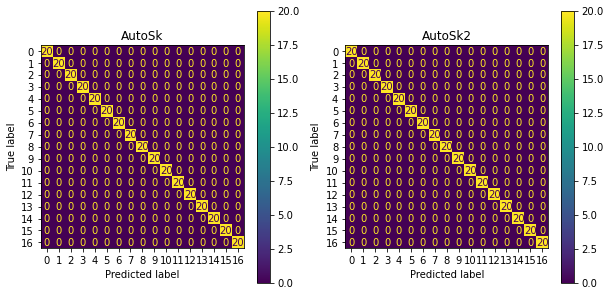

In [17]:
fig, axs = plt.subplots(ncols=n_models2, nrows=1, figsize=(n_models2*5,5))

#Loop principal, iterando sobre as listas
for model, ax in zip(models2, axs):
    
    #print(params)
    model_name = model[0]
    print('Iniciando avaliação do modelo: {}'.format(model_name))
    
    #Primeira etapa - criacao do Pipeline
    pipeline = model[1]#declara_Pipeline_MinMax(model)
    
    t0 = datetime.now()
    
    #rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)
    
    rdmsearch = pipeline
    
    rdmsearch.fit(X1_tr, y_tr)
    
    print()
    print('    Tempo de execução: {}'.format(datetime.now() - t0))
    print('    Score treino: {}'.format(rdmsearch.score(X1_tr, y_tr)))
    print('    Score teste : {}'.format(rdmsearch.score(X1_te, y_te)))
    print()
    
    #buscando info dos melhores modelos
    leaderboard[model_name] = rdmsearch.leaderboard(detailed=True)
    
    cm = confusion_matrix(y_te, rdmsearch.predict(X1_te))
    cmgraph = ConfusionMatrixDisplay(cm)
    ax.set_title(model_name)
    cmgraph.plot(ax=ax)


In [18]:
leaderboard['AutoSk']

,rank,ensemble_weight,type,cost,duration,config_id,train_loss,seed,start_time,end_time,budget,status,data_preprocessors,feature_preprocessors,balancing_strategy,config_origin
model_id,,,,,,,,,,,,,,,,
81,1,0.08,lda,0.000000,4.874589,79,0.000000,0,1.650568e+09,1.650568e+09,0.0,StatusType.SUCCESS,[],[liblinear_svc_preprocessor],none,Local Search
86,2,0.06,lda,0.000000,4.860683,84,0.000000,0,1.650568e+09,1.650568e+09,0.0,StatusType.SUCCESS,[],[liblinear_svc_preprocessor],none,Local Search
101,3,0.04,lda,0.000000,4.692934,99,0.000000,0,1.650568e+09,1.650568e+09,0.0,StatusType.SUCCESS,[],[liblinear_svc_preprocessor],none,Local Search
91,4,0.02,lda,0.000000,5.749475,89,0.000000,0,1.650568e+09,1.650568e+09,0.0,StatusType.SUCCESS,[],[liblinear_svc_preprocessor],weighting,Local Search
96,5,0.06,lda,0.000000,6.451831,94,0.000000,0,1.650568e+09,1.650568e+09,0.0,StatusType.SUCCESS,[],[liblinear_svc_preprocessor],none,Local Search
74,6,0.02,lda,0.001961,5.809521,72,0.000000,0,1.650568e+09,1.650568e+09,0.0,StatusType.SUCCESS,[],[liblinear_svc_preprocessor],none,Local Search
102,7,0.04,lda,0.001961,4.524262,100,0.000000,0,1.650568e+09,1.650568e+09,0.0,StatusType.SUCCESS,[],[liblinear_svc_preprocessor],weighting,Local Search
29,8,0.04,lda,0.001961,8.415431,27,0.000000,0,1.650567e+09,1.650567e+09,0.0,StatusType.SUCCESS,[],[kitchen_sinks],none,Random Search (sorted)
87,9,0.04,lda,0.001961,9.785389,85,0.000000,0,1.650568e+09,1.650568e+09,0.0,StatusType.SUCCESS,[],[liblinear_svc_preprocessor],weighting,Local Search


In [19]:
leaderboard['AutoSk2']

,rank,ensemble_weight,type,cost,duration,config_id,train_loss,seed,start_time,end_time,budget,status,data_preprocessors,feature_preprocessors,balancing_strategy,config_origin
model_id,,,,,,,,,,,,,,,,
161,1,0.04,passive_aggressive,0.003922,8.042917,160,0.000218,0,1.650571e+09,1.650571e+09,25.00,StatusType.DONOTADVANCE,[],[no_preprocessing],none,Local Search
282,2,0.04,passive_aggressive,0.003922,7.299322,281,0.000436,0,1.650572e+09,1.650572e+09,6.25,StatusType.SUCCESS,[],[no_preprocessing],none,Local Search
279,3,0.02,passive_aggressive,0.003922,7.341762,278,0.000218,0,1.650572e+09,1.650572e+09,25.00,StatusType.DONOTADVANCE,[],[no_preprocessing],none,Local Search
261,4,0.02,passive_aggressive,0.003922,7.792409,260,0.000218,0,1.650571e+09,1.650571e+09,25.00,StatusType.DONOTADVANCE,[],[no_preprocessing],none,Local Search
252,5,0.04,passive_aggressive,0.003922,7.800106,251,0.000218,0,1.650571e+09,1.650571e+09,25.00,StatusType.DONOTADVANCE,[],[no_preprocessing],none,Local Search
185,6,0.02,passive_aggressive,0.003922,5.092844,184,0.000654,0,1.650571e+09,1.650571e+09,6.25,StatusType.SUCCESS,[],[no_preprocessing],none,Random Search
181,7,0.02,passive_aggressive,0.003922,4.339899,180,0.003486,0,1.650571e+09,1.650571e+09,25.00,StatusType.DONOTADVANCE,[],[no_preprocessing],none,Local Search
171,8,0.02,passive_aggressive,0.003922,8.212236,170,0.000436,0,1.650571e+09,1.650571e+09,25.00,StatusType.DONOTADVANCE,[],[no_preprocessing],none,Local Search
286,9,0.02,sgd,0.003922,5.710439,285,0.000436,0,1.650572e+09,1.650572e+09,6.25,StatusType.SUCCESS,[],[no_preprocessing],weighting,Random Search
